Import des modules nécéssaires au projet:

In [10]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import math
import time

Initialisation des valeurs:

In [11]:
temperatures_montreal = np.load("Temperatures-Montreal.npy")
eta = 0.99
max_pump_power = 1 # kW
Cp = 0.4 # °C/1kWh
T_min = 19 # °C
T_max = 21 # °C
inconfort_penality_supp = 1
inconfort_penality_inf = 3
ref_week_start_idx = 13050 # mi-avril 
arbitrary_week_start_idx = 0 #30240 # mi-octobre (arbitrary)
computing_intervals_amount = 7*24*4 
task_3_step = 10 # arbitrary
mid_temperature = (T_max + T_min)//2  
task_2_budget_coefficient = 0.75 # arbitrary

# initialisation du tarif bi-horaire pour les couts d'éléctricité
electricity_cost = [0.18 if (i % (24*4)) /4 >= 22 or (i % (24*4))/4 < 7 else 0.26 for i in range(len(temperatures_montreal))] 

#Fonction qui renvoie la COP de chauffe
def COP_warming(T_ext):
    return 3 + 10 * abs(np.tanh(T_ext/100)) * np.tanh(T_ext/100)

#Fonction qui renvoie la COP de refroidissement
def COP_reverse():
    return 3.2

Fonction pour la tache 1 et 2:

In [12]:
#Fonction qui renvoie la chaleur perdue sans action de la pompe
def next_temperature(T_old, T_ext):
    return - (1-eta) * (T_old - T_ext) + T_old

#Fonction qui effectue la tache 1 et 2 (pour passer a la tache 2, il faut définir max_cost):
def basic(first_interval_idx, max_cost=math.inf):
    inconfort_mode = max_cost != math.inf
    last_interval_idx = first_interval_idx + computing_intervals_amount                                 
    temperatures_ext = temperatures_montreal[first_interval_idx:last_interval_idx]

    p_warming = cp.Variable(computing_intervals_amount, nonneg=True)                                    # Puissance de la pompe à l'intervalle i en réchauffement
    p_reverse = cp.Variable(computing_intervals_amount, nonneg=True)                                    # Puissance de la pompe à l'intervalle i en reverse
    temperatures_int = cp.Variable(computing_intervals_amount)                                          # Températures intérieures
    partial_electricity_cost = electricity_cost[first_interval_idx:last_interval_idx]                   # Coût de l'électricité sur la période sélectionnée
    
    cost = cp.sum(partial_electricity_cost @ (p_warming + p_reverse) * 4)

    constraints = [p_warming >= 0]
    constraints += [p_reverse >= 0]
    constraints += [p_warming <= max_pump_power]
    constraints += [p_reverse <= max_pump_power]
    constraints += [temperatures_int[0] == mid_temperature]
    constraints += [temperatures_int[-1] == mid_temperature]
    constraints += [temperatures_int[1:] == next_temperature(temperatures_int[:-1], temperatures_ext[:-1]) 
    + cp.multiply(COP_warming(temperatures_ext[:-1]), p_warming[:-1]) * 4 * Cp 
    - cp.multiply(COP_reverse(), p_reverse[:-1] * 4 * Cp)
    ]

    if inconfort_mode:
        inconforts_sup = cp.Variable(computing_intervals_amount, nonneg=True)
        inconforts_inf = cp.Variable(computing_intervals_amount, nonneg=True)
        objective = cp.sum(inconforts_sup*inconfort_penality_supp + inconfort_penality_inf*inconforts_inf)
        constraints += [cost <= max_cost]
        constraints += [temperatures_int - T_min >= -inconforts_inf]
        constraints += [temperatures_int - T_max <= inconforts_sup]
    else:
        constraints += [temperatures_int >= T_min]
        constraints += [temperatures_int <= T_max]
        objective = cost
    

    problem = cp.Problem(cp.Minimize(objective), constraints)
    start_time = time.time()
    solution = problem.solve(solver=cp.SCIPY, scipy_options={"method": "highs"}, warm_start=inconfort_mode)
    end_time = time.time()

    if cost.value is None: 
        return []
    return [temperatures_int.value, p_warming.value, p_reverse.value, cost.value, problem.value, end_time - start_time]

Tache 3:

In [13]:
#Fonction qui effectue la tache 3
def task3(first_interval_idx, max_cost):
    last_interval_idx = first_interval_idx + computing_intervals_amount
    outputs = []
    max_allocated_budget = np.linspace(0, max_cost, num=100//task_3_step+1) 
    for i in range(len(max_allocated_budget)):
        output = basic(first_interval_idx, max_allocated_budget[i]) #effectue la tache 2 en changeant le budget par la boucle for
        outputs.append(output)
    return outputs

Plot pour la tache 1:

In [14]:
#Fonction qui plot la tache 1
def plot_1(period_1, period_2, period_1_first_interval_idx, period_2_first_interval_idx): 
    periods = [period_1, period_2]
    first_interval_idxs = [period_1_first_interval_idx, period_2_first_interval_idx]
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

    for i in range(len(periods)):
        period = periods[i] 
        first_interval_idx = first_interval_idxs[i]
        last_interval_idx = first_interval_idx + computing_intervals_amount

        x = np.linspace(first_interval_idx, last_interval_idx, computing_intervals_amount)

        axs[0][i].plot(x, period[0])
        axs[0][i].set_title("Période {i} - Évolution des températures".format(i=i+1))
        axs[0][i].set_xlabel("Intervalle de temps")
        axs[0][i].set_ylabel("Température (°C)")

        axs[1][i].plot(x, period[1], label="Fonctionnement normal")
        axs[1][i].plot(x, period[2], label="Fonctionnement reverse")
        axs[1][i].set_title("Période {i} - Utilisation de la pompe à chaleur".format(i=i+1))
        axs[1][i].set_xlabel("Intervalle de temps")
        axs[1][i].set_ylabel("Puissance (kW)")
        axs[1][i].legend()
        print("1. Coût période {i} : {cost}".format(i=i+1, cost=period[3]))
        plt. gcf(). subplots_adjust( wspace = 0.7, hspace = 1) 

    fig.canvas.manager.set_window_title("Tâche 1 - Minimisation du coût avec T_min <= T <= T_max")
    plt.show()

Plot pour la tache 2:

In [15]:
#Fonction qui plot la tache 2
def plot_2(period_1, period_2, period_1_first_interval_idx, period_2_first_interval_idx):
    periods = [period_1, period_2]
    first_interval_idxs = [period_1_first_interval_idx, period_2_first_interval_idx]
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

    for i in range(len(periods)):
        period = periods[i] 
        first_interval_idx = first_interval_idxs[i]
        last_interval_idx = first_interval_idx + computing_intervals_amount

        x = np.linspace(first_interval_idx, last_interval_idx, computing_intervals_amount)

        axs[0][i].plot(x, period[0])
        axs[0][i].set_title("Période  {i} - Évolution des températures".format(i=i+1))
        axs[0][i].set_xlabel("Intervalle de temps")
        axs[0][i].set_ylabel("Température (°C)")

        x = np.linspace(first_interval_idx, last_interval_idx, computing_intervals_amount)

        axs[1][i].plot(x, period[1], label="Fonctionnement normal")
        axs[1][i].plot(x, period[2], label="Fonctionnement reverse")
        axs[1][i].set_title("Période {i} - Utilisation de la pompe à chaleur".format(i=i+1))
        axs[1][i].set_xlabel("Intervalle de temps")
        axs[1][i].set_ylabel("Puissance (kW)")
        axs[1][i].legend()

        plt. gcf(). subplots_adjust( wspace = 0.7, hspace = 1) 

        print("2. Inconfort minimal de {inconfort} pour un budget de {budget} à la période {p}".format(inconfort=period[4], budget=period[3], p=i+1))

    fig.canvas.manager.set_window_title("Tâche 2 - Minimisation de l'inconfort avec budget restreint d'un facteur {f}".format(f=task_2_budget_coefficient))
    plt.show()

Plot pour la tache 3:

In [16]:
#Fonction qui plot la tache 3
def plot_3(period_1, period_2, period_1_first_interval_idx, period_2_first_interval_idx):
    periods = [period_1, period_2]
    first_interval_idxs = [period_1_first_interval_idx, period_2_first_interval_idx]

    total_computation_time = 0

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
    for i in range(len(periods)):
        period = periods[i]
        first_interval_idx = first_interval_idxs[i]
        last_interval_idx = first_interval_idx + computing_intervals_amount

        time = np.linspace(first_interval_idx, last_interval_idx, computing_intervals_amount)
        budget = [o[3] if len(o) != 0 else math.inf for o in period]
        inconfort = [o[4] if len(o) != 0 else math.inf for o in period]

        axs[0][i].set_title("Période {i} - Évolution des températures".format(i=i+1))
        axs[0][i].set_xlabel("Intervalle de temps")
        axs[0][i].set_ylabel("Température (°C)")

        axs[1][i].set_title("Période {i} - Évolution des inconforts".format(i=i+1))
        axs[1][i].set_xlabel("Budget alloué")
        axs[1][i].set_ylabel("Inconfort")

        for o in range(len(period)):
            output = period[o]
            if len(output) == 0:
                print("3. Temps de résolution du problème {o} à la période {p} (index initial : {i}): {t}s".format(p=i+1, o=o+1, t=0, i=first_interval_idx))
                continue

            computation_time = output[5]
            total_computation_time += computation_time
            print("3. Temps de résolution du problème {o} à la période {p} (index initial : {i}): {t}s".format(p=i+1, o=o+1, t=computation_time, i=first_interval_idx))

            axs[0][i].plot(time, output[0], label="{percent}%".format(percent=o*task_3_step))
            plt. gcf(). subplots_adjust( wspace = 0.7, hspace = 1)

        print("3. Temps de résolution pour la période {p} (index initial {i}) : {t}s".format(p=i+1, i=first_interval_idx, t=total_computation_time))
        axs[1][i].plot(budget, inconfort, "o-", color='red')
        axs[0][i].legend(loc='center left', bbox_to_anchor=(1,0.5))

    fig.canvas.manager.set_window_title("Tâche 3 - Minimisation de l'inconfort avec budget restreint à {step}n%".format(step=task_3_step))
    plt.show()

Main:

Computed output_1_ref in 0.03659844398498535s
Computed output_1_arbitrary in 0.0382847785949707s
Computed output_2_arbitrary in 0.09950447082519531s
Computed output_2_arbitrary in 0.12806105613708496s
Computed output_3_ref in 1.1081767082214355s
Computed output_3_arbitrary in 1.3611173629760742s
1. Coût période 1 : 8.089750742486272
1. Coût période 2 : 33.82349763679302


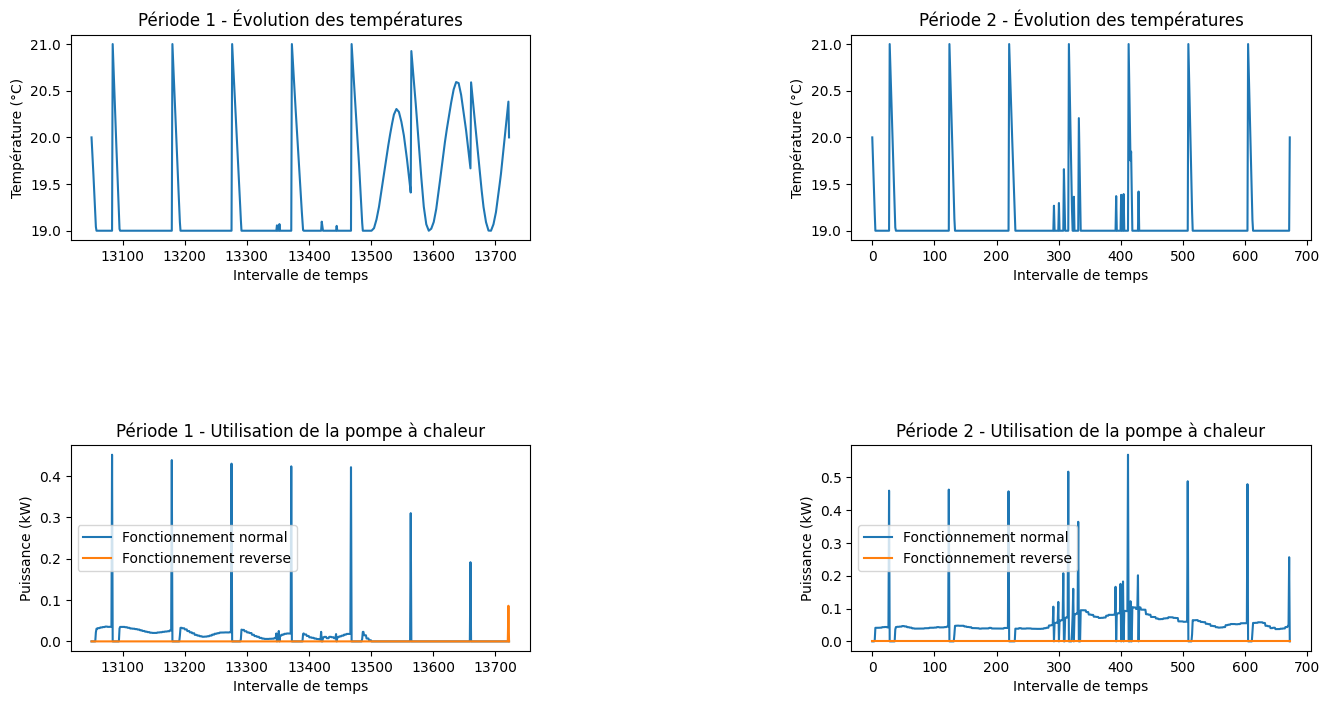

2. Inconfort minimal de 1195.055333269614 pour un budget de 6.0673130568647 à la période 1
2. Inconfort minimal de 4363.487540975305 pour un budget de 25.367623227594798 à la période 2


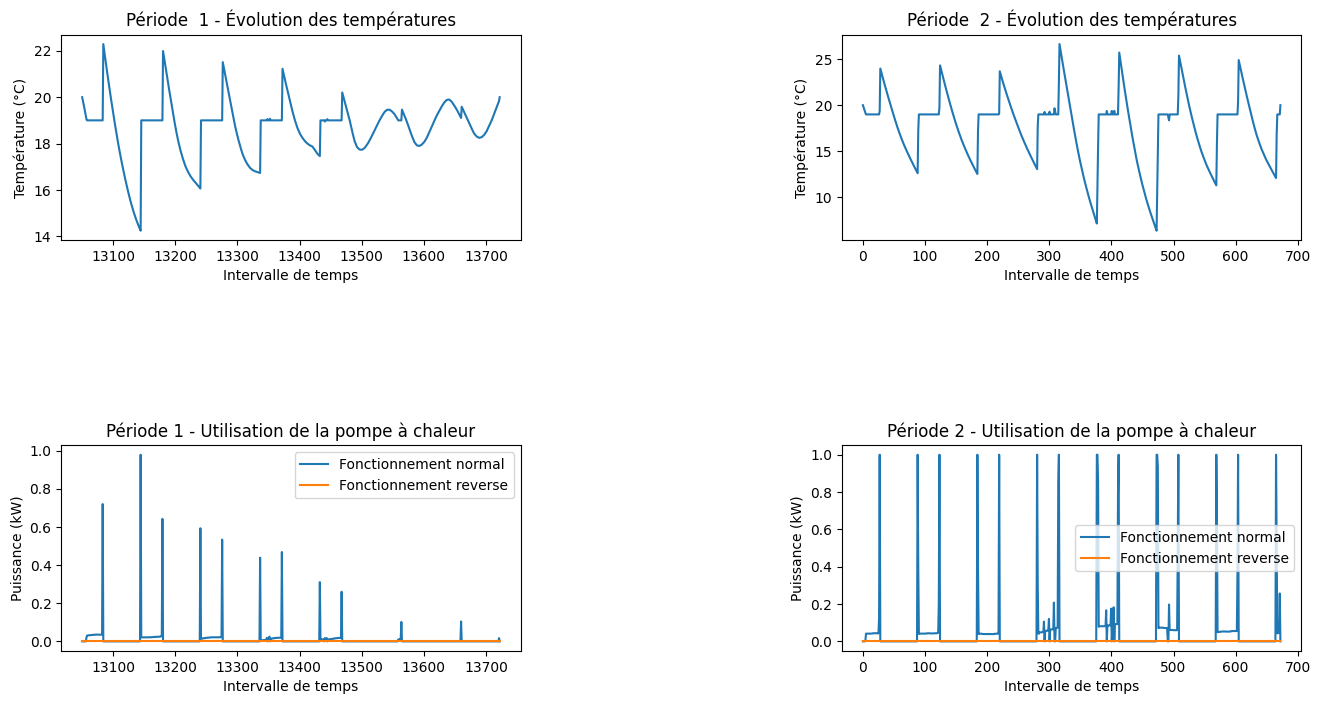

3. Temps de résolution du problème 1 à la période 1 (index initial : 13050): 0s
3. Temps de résolution du problème 2 à la période 1 (index initial : 13050): 0.0887308120727539s
3. Temps de résolution du problème 3 à la période 1 (index initial : 13050): 0.09647202491760254s
3. Temps de résolution du problème 4 à la période 1 (index initial : 13050): 0.10460519790649414s
3. Temps de résolution du problème 5 à la période 1 (index initial : 13050): 0.10863161087036133s
3. Temps de résolution du problème 6 à la période 1 (index initial : 13050): 0.11137771606445312s
3. Temps de résolution du problème 7 à la période 1 (index initial : 13050): 0.11014127731323242s
3. Temps de résolution du problème 8 à la période 1 (index initial : 13050): 0.10826826095581055s
3. Temps de résolution du problème 9 à la période 1 (index initial : 13050): 0.15080499649047852s
3. Temps de résolution du problème 10 à la période 1 (index initial : 13050): 0.08546996116638184s
3. Temps de résolution du problème 11 

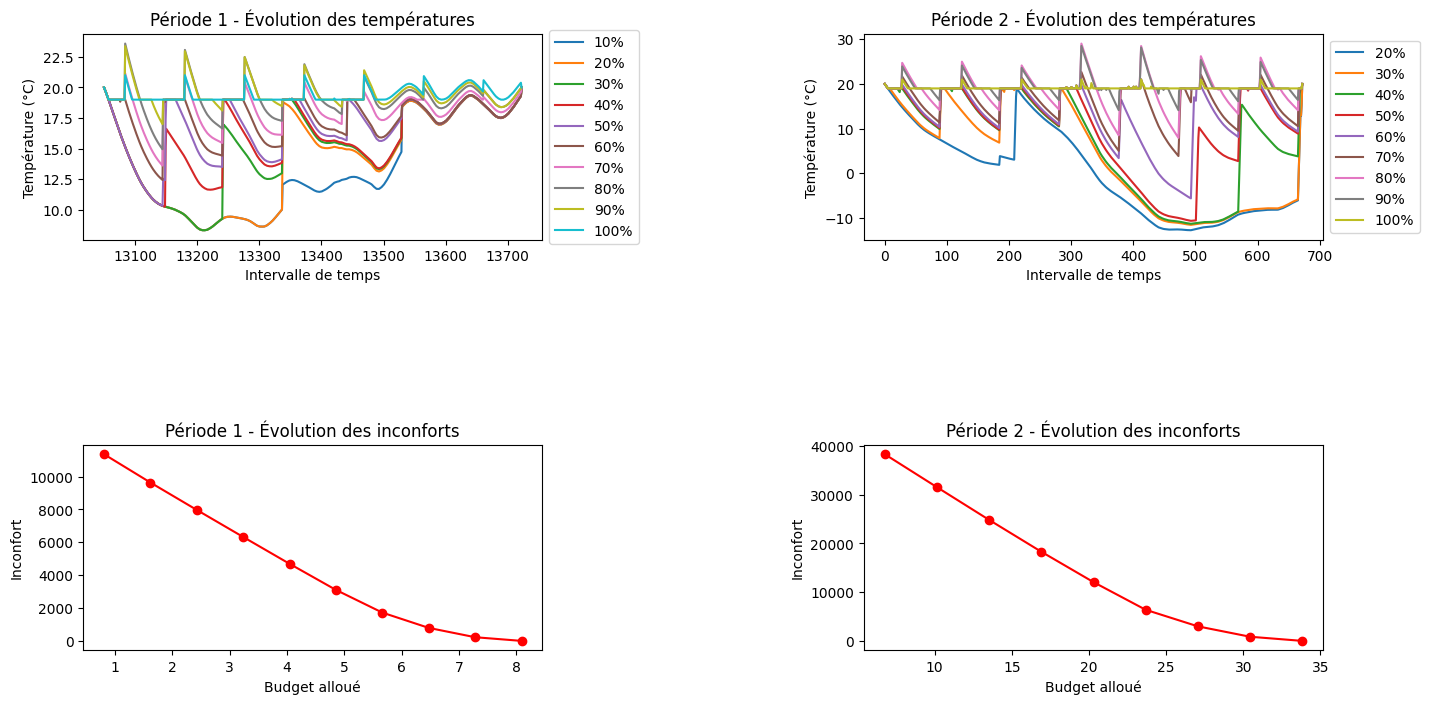

In [17]:
output_1_ref = basic(ref_week_start_idx)
print("Computed output_1_ref in {time}s".format(time=output_1_ref[-1]))
output_1_arbitrary = basic(arbitrary_week_start_idx)
print("Computed output_1_arbitrary in {time}s".format(time=output_1_arbitrary[-1]))

output_2_ref = basic(ref_week_start_idx, output_1_ref[3]*task_2_budget_coefficient)
print("Computed output_2_arbitrary in {time}s".format(time=output_2_ref[-1]))

output_2_arbitrary = basic(arbitrary_week_start_idx, output_1_arbitrary[3]*task_2_budget_coefficient)
print("Computed output_2_arbitrary in {time}s".format(time=output_2_arbitrary[-1]))

start = time.time()
output_3_ref = task3(ref_week_start_idx, output_1_ref[3])
print("Computed output_3_ref in {time}s".format(time=time.time()-start))

start = time.time()
output_3_arbitrary = task3(arbitrary_week_start_idx, output_1_arbitrary[3])
print("Computed output_3_arbitrary in {time}s".format(time=time.time()-start))

plot_1(output_1_ref, output_1_arbitrary, ref_week_start_idx, arbitrary_week_start_idx) 
plot_2(output_2_ref, output_2_arbitrary, ref_week_start_idx, arbitrary_week_start_idx)
plot_3(output_3_ref, output_3_arbitrary, ref_week_start_idx, arbitrary_week_start_idx)